In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Dataloaders for ShapeNetCore
This tutorial shows how to:
- Load models from ShapeNetCore using PyTorch3D's data loaders.
- Pass the loaded datasets to `torch.utils.data.DataLoader`.
- Render ShapeNetCore models with PyTorch3D's renderer.

In [1]:
import numpy as np
import torch

from pytorch3d.datasets import (
    ShapeNetCore,
    collate_batched_meshes,
    render_cubified_voxels,
)
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,
)

from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import plot_scene

from pytorch3d.structures import Meshes
from torch.utils.data import DataLoader
from plot_image_grid import image_grid

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

## 1. Load the datasets

If you haven't already downloaded the ShapeNetCore dataset, first do that following the instructions here: https://www.shapenet.org/. ShapeNetCore is a subset of the ShapeNet dataset. In PyTorch3D we support both version 1 (57 categories) and version 2 (55 categories).

Then modify `SHAPENET_PATH` below to you local path to the ShapeNetCore dataset folder. 

In [2]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

In [4]:
SHAPENET_PATH = "D:/ShapeNet"#"C:\\Users\\lmtop\\Documents\\ShapeNetTest\\ShapeNet"
#"D:/ShapeNet"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, version=2)

c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 207e69af994efa9330714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 2307b51ca7e4a03d30714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 302612708e86efea62d2c237bfbc22ca under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 3c33f9f8edc558ce77aa0b62eed1492 under synset directory 02958343.
  warnings.warn(ms

We can retrieve a model by indexing into the loaded dataset. For both ShapeNetCore and R2N2, we can examine the category this model belongs to (in the form of a synset id, equivalent to wnid described in ImageNet's API: http://image-net.org/download-API), its model id, and its vertices and faces.

In [5]:
print(len(shapenet_dataset))

52472


In [ ]:
from pytorch3d.structures import VoxelGrids
from pytorch3d.vis.plotly_vis import plot_voxel_grid
import binvox_rw

# get a model from the dataset
model_path = shapenet_dataset[0]["model"]

# read the .binvox file
with open(model_path, 'rb') as f:
    model = binvox_rw.read_as_3d_array(f)

# convert the model to a VoxelGrids object
voxel_grid = VoxelGrids([torch.Tensor(model.data)])

# visualize the voxel grid
plot_voxel_grid(voxel_grid)

In [45]:
shapenet_model = shapenet_dataset[7]
print("This model belongs to the category " + shapenet_model["synset_id"] + ".")
print("This model has model id " + shapenet_model["model_id"] + ".")
model_verts, model_faces = shapenet_model["verts"], shapenet_model["faces"]

This model belongs to the category 04074963.
This model has model id 28f2a5df4a926c3e140a527375fd6757.


We can use its vertices and faces to form a `Meshes` object which is a PyTorch3D datastructure for working with batched meshes.

In [46]:
model_textures = TexturesVertex(verts_features=torch.ones_like(model_verts, device=device)[None])
shapenet_model_mesh = Meshes(
    verts=[model_verts.to(device)],   
    faces=[model_faces.to(device)],
    textures=model_textures
)

## 3. Render ShapeNetCore models with PyTorch3D's differentiable renderer

Both `ShapeNetCore` and `R2N2` dataloaders have customized `render` functions that support rendering models by specifying their model ids, categories or indices using PyTorch3D's differentiable renderer implementation.

In [47]:
# Rendering settings.
R, T = look_at_view_transform(1.0, 1.0, 90)
cameras = OpenGLPerspectiveCameras(R=R, T=T, device=device)
raster_settings = RasterizationSettings(image_size=512)
lights = PointLights(location=torch.tensor([0.0, 1.0, -2.0], device=device)[None],device=device)

First we will try to render three models by their model ids:

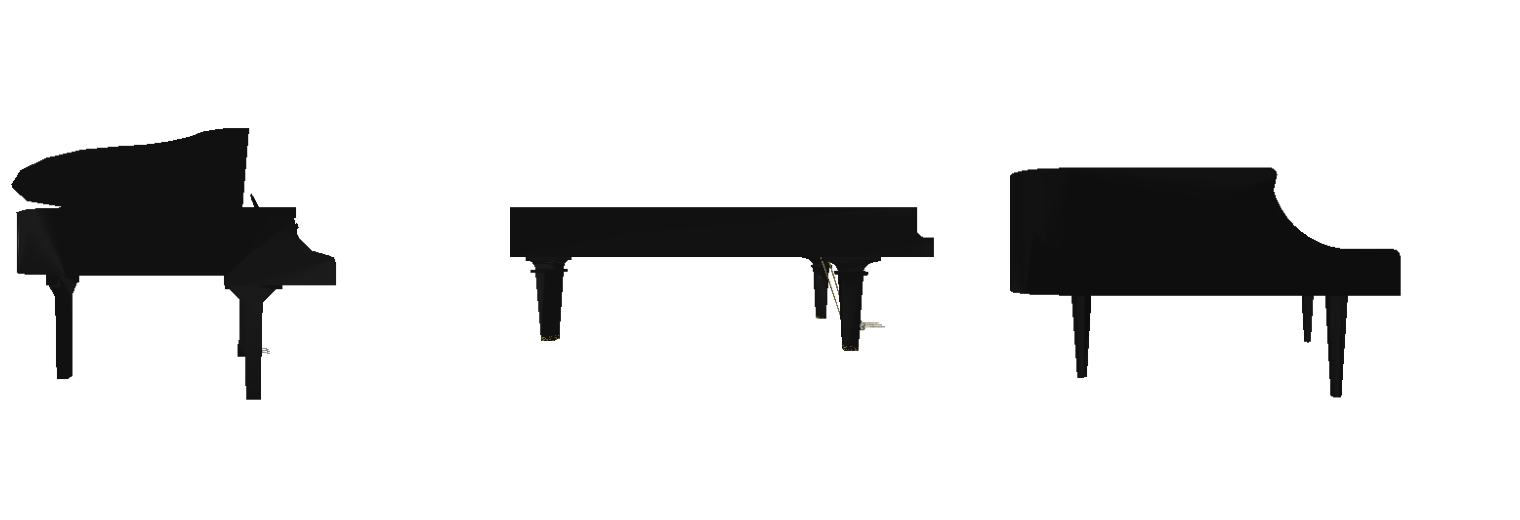

In [48]:
images_by_model_ids = shapenet_dataset.render(
    model_ids=[
        "13394ca47c89f91525a3aaf903a41c90",
        "14755c2ee8e693aba508f621166382b0",
        "156c4207af6d2c8f1fdc97905708b8ea",
    ],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_model_ids.cpu().numpy(), rows=1, cols=3, rgb=True)

Suppose we would like to render the first three models in the dataset, we can render models by their indices:

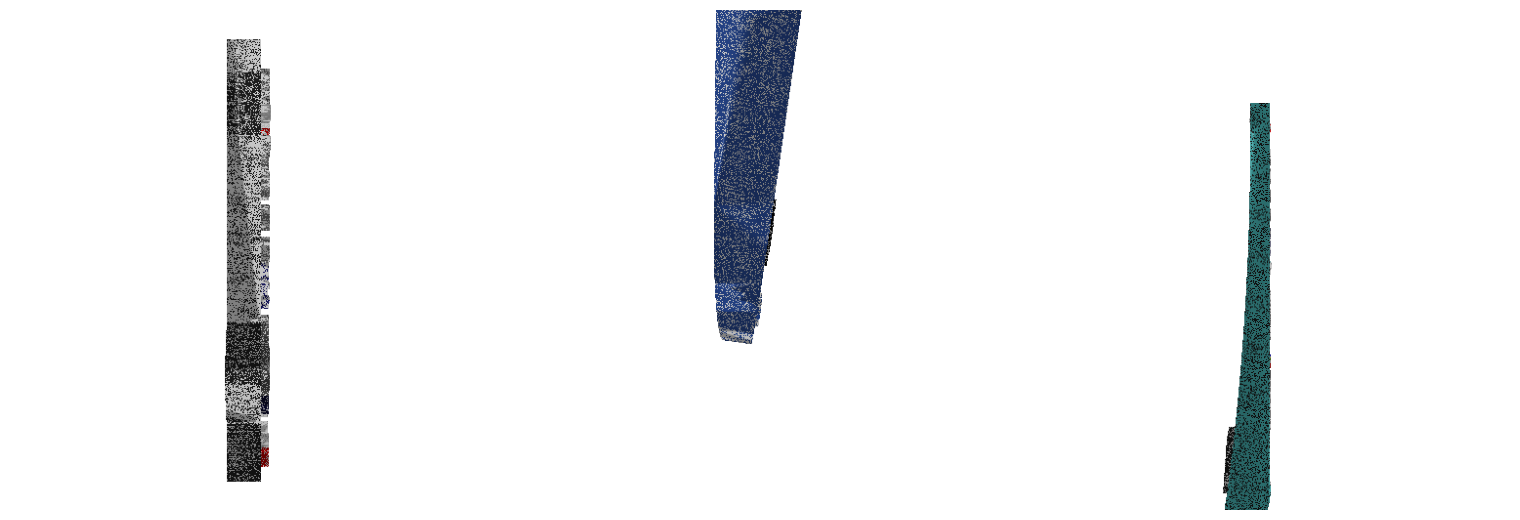

In [49]:
images_by_idxs = shapenet_dataset.render(
    idxs=list(range(3)),
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_idxs.cpu().numpy(), rows=1, cols=3, rgb=True)

Alternatively, if we are not interested in any particular models but would like see random models from some specific categories, we can do that by specifying `categories` and `sample_nums`. For example, if we would like to render 2 models from the category "faucet" and 3 models from the category "chair", we can do the following:

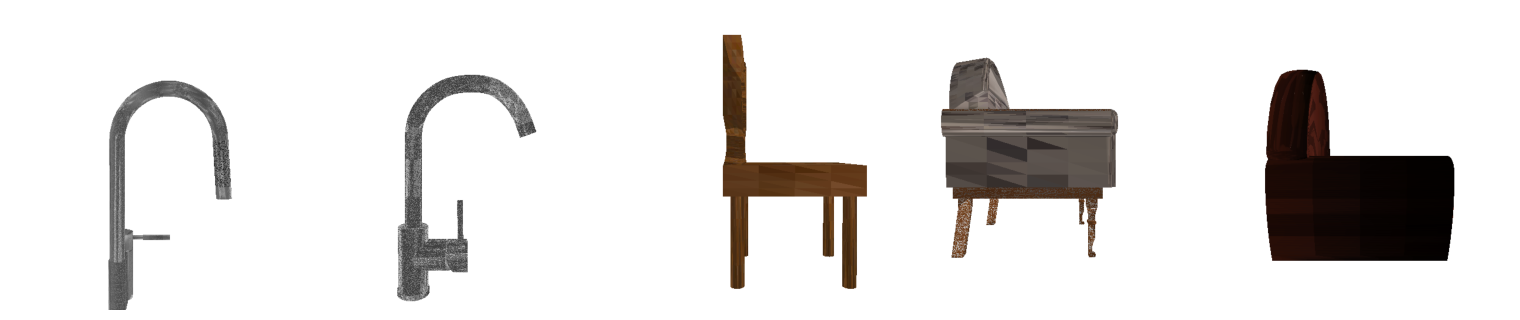

In [50]:
images_by_categories = shapenet_dataset.render(
    categories=["faucet", "chair"],
    sample_nums=[2, 3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(images_by_categories.cpu().numpy(), rows=1, cols=5, rgb=True)

If we are not interested in any particular categories and just would like to render some random models from the whole dataset, we can set the number of models to be rendered in `sample_nums` and not specify any `categories`:

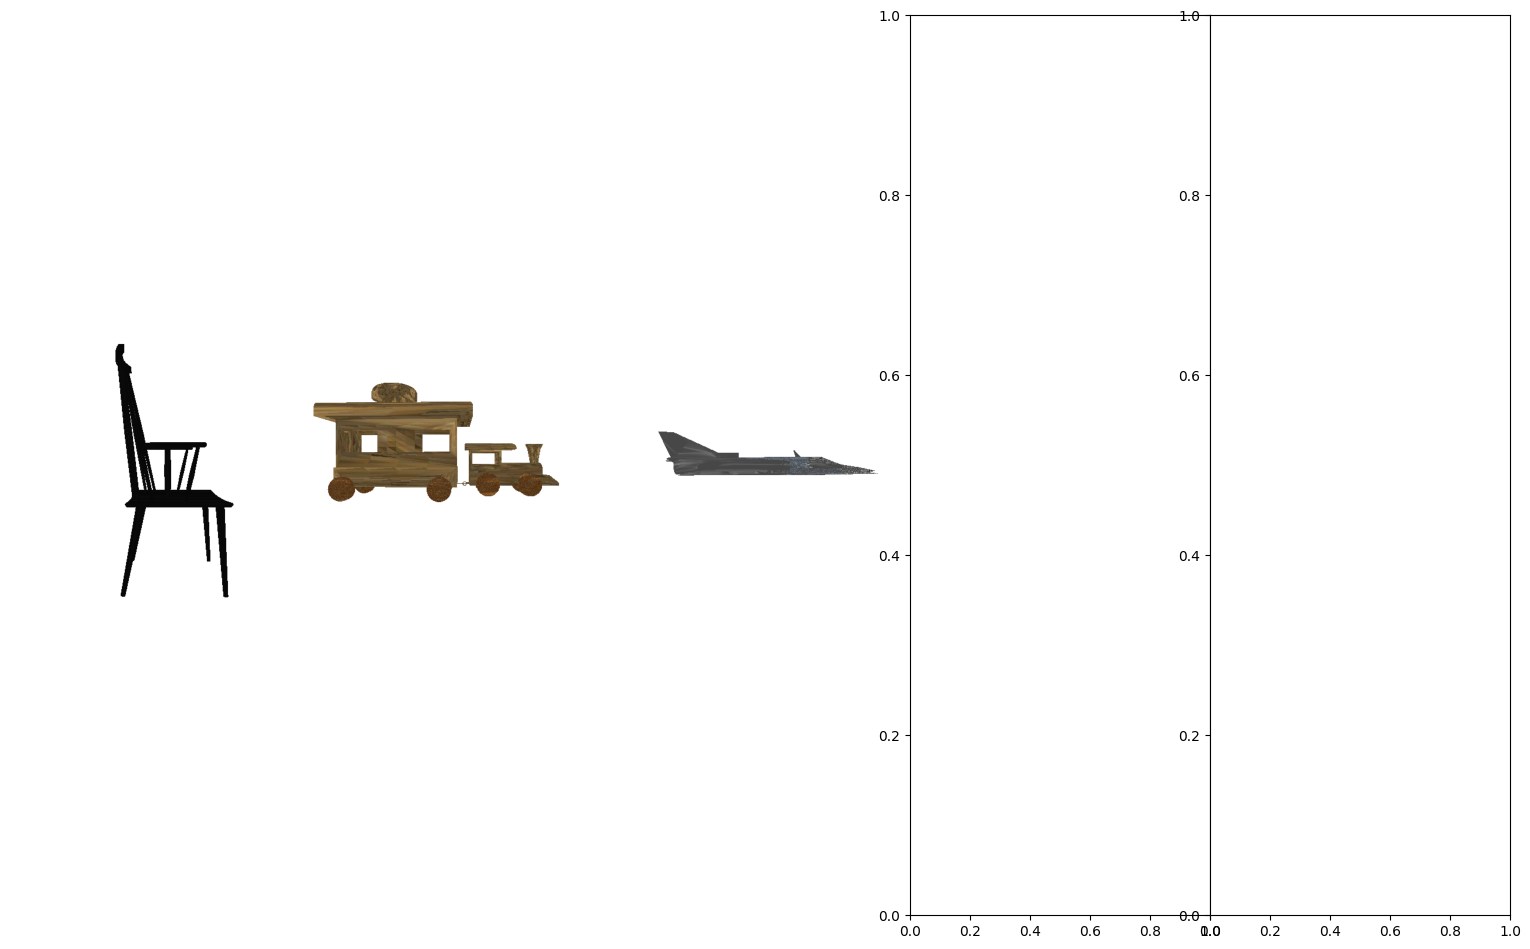

In [59]:
random_model_images = shapenet_dataset.render(
    sample_nums=[3],
    device=device,
    cameras=cameras,
    raster_settings=raster_settings,
    lights=lights,
)
image_grid(random_model_images.cpu().numpy(), rows=1, cols=5, rgb=True)

In [68]:


# get a model from the dataset
model = shapenet_dataset[0]

# create a Meshes object from the model's vertices and faces
mesh = Meshes(verts=[torch.Tensor(model['verts'])], 
              faces=[torch.Tensor(model['faces']).int()])

# visualize the mesh
fig = plt.figure(figsize=(10, 10))
plot_meshes(mesh, fig=fig)

NameError: name 'plt' is not defined